# AutoML in Python: A comparison between Hyperopt Sklearn and TPOT
In this tutorial I compare two Python packages for Auto Machine Learning: `Hyperopt Sklearn` and `TPOT`.


## Data preparation
Firstly, I load the dataset through the Python `pandas` library. I exploit the `heart.csv` dataset, provided by the [Kaggle repository](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset).

In [361]:
import pandas as pd

df = pd.read_csv('source/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Now, I split the columns of the dataset in input (`X`) and output (`Y`). I use all the columns but `output` as input features. 

In [362]:
features = []
for column in df.columns:
    if column != 'output':
        features.append(column)
X = df[features]
y = df['output']

I split the dataset into training and test sets. I exploit the `scikit-learn` function `train_test_split()`.

In [363]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Hyperopt Sklearn

Now we can train the HyperoptEstimator to search for the best classifier.

In [376]:
from hpsklearn import HyperoptEstimator

# Create the estimator object
estim = HyperoptEstimator()

# Search the space of classifiers and preprocessing steps and their
# respective hyperparameters in sklearn to fit a model to the data
estim.fit( X_train, y_train )

100%|██████████| 10/10 [00:02<00:00,  2.92s/trial, best loss: 0.14634146341463417]


Retrieve the best model

In [377]:
# Return instances of the classifier and preprocessing steps
best_model = estim.best_model()
best_model

{'learner': GradientBoostingClassifier(learning_rate=0.00813591154617836, max_depth=None,
                            max_features=0.6562885234780235, min_samples_leaf=11,
                            n_estimators=63, random_state=0,
                            subsample=0.68797222866341),
 'preprocs': (MinMaxScaler(feature_range=(-1.0, 1.0)),),
 'ex_preprocs': ()}

Get the model

In [406]:
model = best_model['learner']
model

GradientBoostingClassifier(learning_rate=0.00813591154617836, max_depth=None,
                           max_features=0.6562885234780235, min_samples_leaf=11,
                           n_estimators=63, random_state=0,
                           subsample=0.68797222866341)

Get preprocessing and apply it to X_train and X_test

In [381]:
X_train_norm = X_train
X_test_norm = X_test
if len(best_model['preprocs']) > 0:
    preprocs = best_model['preprocs'][0]
    X_train_norm = preprocs.transform(X_train)
    X_test_norm = preprocs.transform(X_test)

If the best model is SVC, set the parameter probability = True to exploit the predict_proba() function.

In [384]:
from sklearn.svm import SVC

if isinstance(model, SVC):
    model.set_params(probability=True)
    model.fit(X_train_norm,y_train)

Calculate the ROC curve and the precision recall curve

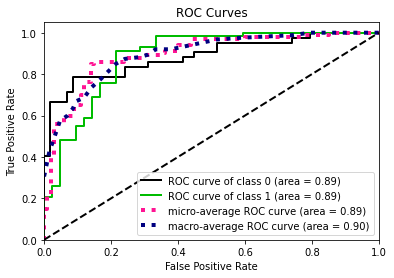

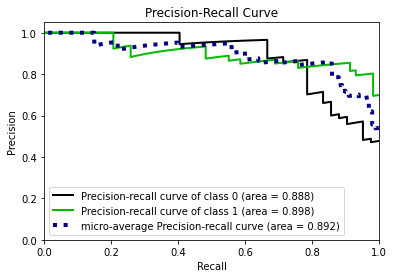

In [386]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from scikitplot.metrics import plot_roc,auc
from scikitplot.metrics import plot_precision_recall

y_score_hp = model.predict_proba(X_test_norm)
# Plot metrics 
plot_roc(y_test, y_score_hp)
plt.show()
    
plot_precision_recall(y_test, y_score_hp)
plt.show()

Calculate precision, recall and accuracy.

In [383]:
y_test_pred = model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
print('accuracy:  %s ' %(round(accuracy, 2)))
print('precision:  %s ' %(round(precision, 2)))
print('recall:  %s ' %(round(recall, 2)))

accuracy:  0.85 
precision:  0.85 
recall:  0.9 


## Retrain the model with kFold

In [407]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc

kf = KFold(n_splits=10,random_state=42,shuffle=True)


accuracy_trains = []
accuracy_tests = []
precision_trains = []
precision_tests = []
recall_trains = []
recall_tests = []


n = kf.get_n_splits()
for train_index, test_index in kf.split(X):
    
    X_train_c, X_test_c = X.iloc[train_index], X.iloc[test_index]
    y_train_c, y_test_c = y[train_index], y[test_index]
    
    X_train_norm = X_train_c
    X_test_norm = X_test_c
    if len(best_model['preprocs']) > 0:
        X_train_norm = preprocs.transform(X_train_c)
        X_test_norm = preprocs.transform(X_test_c)
    
    model.fit(X_train_norm,y_train_c)
    y_train_pred = model.predict(X_train_norm)
    y_test_pred = model.predict(X_test_norm)
    
    
    precision_train = precision_score(y_train_c, y_train_pred)
    precision_trains.append(precision_train)
    
    precision_test = precision_score(y_test_c, y_test_pred)
    precision_tests.append(precision_test)
    
    recall_train = recall_score(y_train_c, y_train_pred)
    recall_trains.append(recall_train)
    
    recall_test = recall_score(y_test_c, y_test_pred)
    recall_tests.append(recall_test)
    
    
    accuracy_train = accuracy_score(y_train_c, y_train_pred)
    accuracy_trains.append(accuracy_train)
    
    accuracy_test = accuracy_score(y_test_c, y_test_pred)
    accuracy_tests.append(accuracy_test)
    
    

In [408]:
def plot_metrics(folds,metrics_train,metrics_test, ylabel):
    plt.plot(folds, metrics_train, 'o-', color='green', label='train')
    plt.plot(folds, metrics_test, 'o-', color='red', label='test')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of fold')
    plt.ylabel(ylabel)
    plt.show()


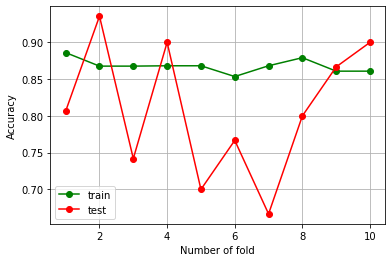

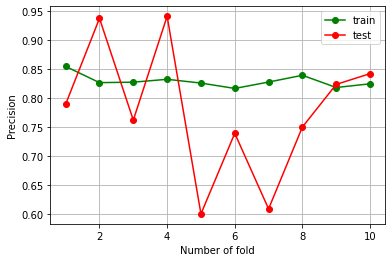

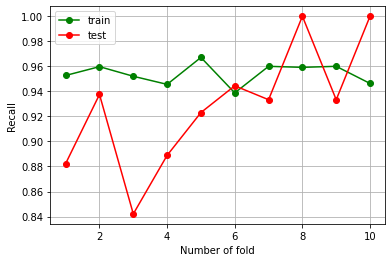

In [409]:
folds = range(1, kf.get_n_splits() + 1)
plot_metrics(folds, accuracy_trains,accuracy_tests, 'Accuracy')
plot_metrics(folds, precision_trains,precision_tests, 'Precision')
plot_metrics(folds, recall_trains,recall_tests, 'Recall')

In [357]:
print('accuracy:  %s ' %(round(np.mean(accuracy_tests), 2)))
print('precision:  %s ' %(round(np.mean(precision_tests), 2)))
print('recall:  %s ' %(round(np.mean(recall_tests), 2)))

accuracy:  0.86 
precision:  0.84 
recall:  0.91 


# TPOT

In [389]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=50, random_state=42)
tpot.fit(X_train, y_train)

TPOTClassifier(generations=5, population_size=50, random_state=42)

Calculate metrics:

In [394]:
y_test_pred = tpot.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
print('accuracy:  %s ' %(round(accuracy, 2)))
print('precision:  %s ' %(round(precision, 2)))
print('recall:  %s ' %(round(recall, 2)))

accuracy:  0.8 
precision:  0.84 
recall:  0.81 


Calculate ROC curve and precision and recall curve

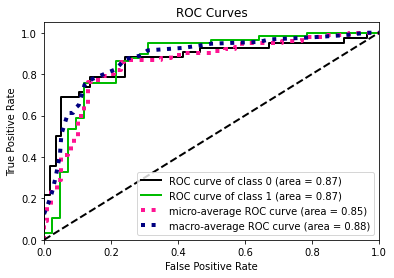

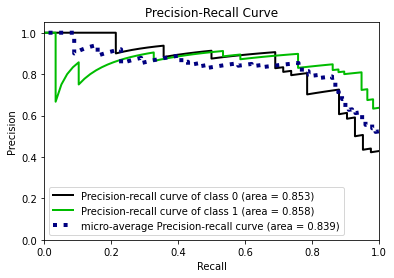

In [396]:
y_score_tpot = tpot.predict_proba(X_test)
# Plot metrics 
plot_roc(y_test, y_score_tpot)
plt.show()
    
plot_precision_recall(y_test, y_score_tpot)
plt.show()

Get the best model

In [391]:
tpot.fitted_pipeline_

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=20.0, random_state=42))])

In [410]:
model = tpot.fitted_pipeline_

## KFold
TPOT supports cross validation. However, we calculate it manually, because we would like to show the ouput of each fold.

In [411]:
kf = KFold(n_splits=10,random_state=42,shuffle=True)


accuracy_trains = []
accuracy_tests = []
precision_trains = []
precision_tests = []
recall_trains = []
recall_tests = []

fprs = []
tprs = []



n = kf.get_n_splits()
for train_index, test_index in kf.split(X):
    
    X_train_c, X_test_c = X.iloc[train_index], X.iloc[test_index]
    y_train_c, y_test_c = y[train_index], y[test_index]
    
    
    model.fit(X_train_c,y_train_c)
    y_train_pred = tpot.predict(X_train_c)
    y_test_pred = tpot.predict(X_test_c)
    
    
    precision_train = precision_score(y_train_c, y_train_pred)
    precision_trains.append(precision_train)
    
    precision_test = precision_score(y_test_c, y_test_pred)
    precision_tests.append(precision_test)
    
    recall_train = recall_score(y_train_c, y_train_pred)
    recall_trains.append(recall_train)
    
    recall_test = recall_score(y_test_c, y_test_pred)
    recall_tests.append(recall_test)
    
    
    accuracy_train = accuracy_score(y_train_c, y_train_pred)
    accuracy_trains.append(accuracy_train)
    
    accuracy_test = accuracy_score(y_test_c, y_test_pred)
    accuracy_tests.append(accuracy_test)
 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

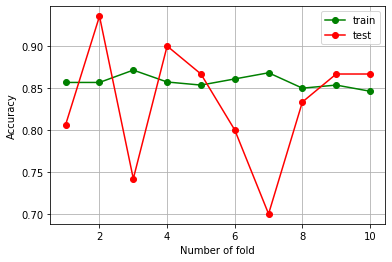

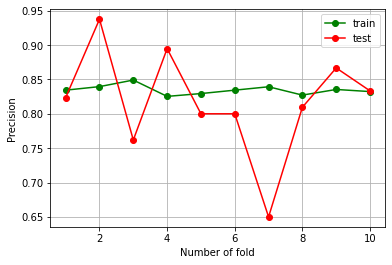

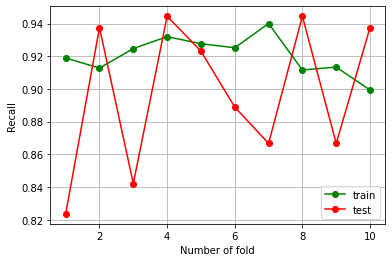

In [413]:
folds = range(1, kf.get_n_splits() + 1)
plot_metrics(folds, accuracy_trains,accuracy_tests, 'Accuracy')
plot_metrics(folds, precision_trains,precision_tests, 'Precision')
plot_metrics(folds, recall_trains,recall_tests, 'Recall')

# References
* https://stackoverflow.com/questions/39315156/how-to-install-xgboost-in-python-on-macos